In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [18]:
data = Path.cwd().parent / 'data'
df = pd.read_csv(data / 'limpo_solicitacoes_doc9.csv',
    parse_dates=[
        'datahora_abertura_solicitacao',
        'datahora_finalizacao_solicitacao',
        'datahora_audiencia',
        'prazo_para_inserir_dados',
        ]
    )
df = df.drop(columns=['Unnamed: 0'])

# Operações
_Pergunta do stakeholder:_

_“Quais fatores mais influenciam para que um parceiro falhe (revelia, ausência ou má atuação)? Conseguimos prever quais solicitações têm maior risco de falha?”_

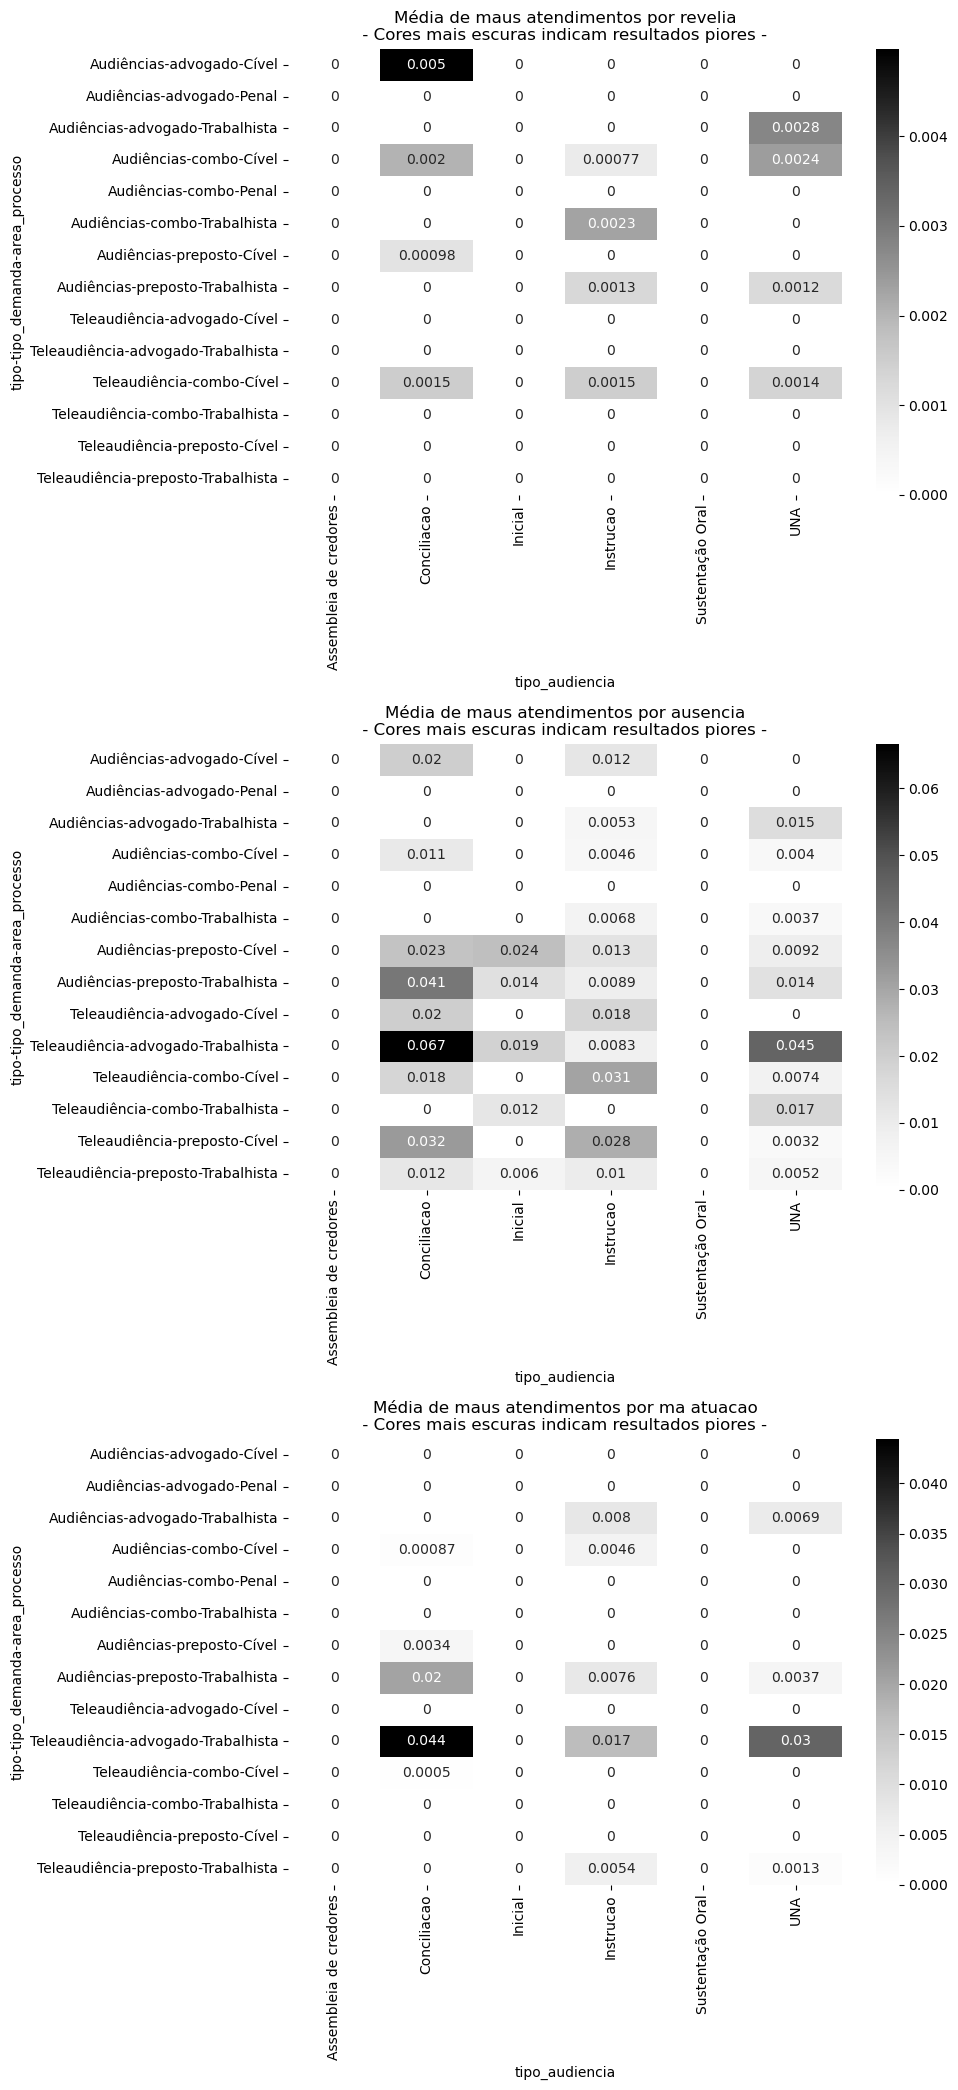

In [3]:
bad_results = ['houve_revelia', 'houve_ausencia', 'houve_ma_atuacao']

fig, axes = plt.subplots(
    nrows=len(bad_results),
    ncols=1,
    figsize=(10, 7 * len(bad_results))
    )

for i, bd in enumerate(bad_results):
    df_falhas = (
        df.groupby(
            ['tipo', 'tipo_demanda', 'area_processo', 'tipo_audiencia']
            )
            [bd]
            .agg('mean')
            .unstack()
            .fillna(0)
        )

    sns.heatmap(
        df_falhas,
        annot=True,
        cmap='Greys',
        ax=axes[i]
    )
    result_title = ' '.join(bd.split('_')[1:])
    axes[i].set_title(
        f'Média de maus atendimentos por {result_title}\n' \
        ' - Cores mais escuras indicam resultados piores - ' 
    )
    

plt.tight_layout()

Os gráficos acima permitem interpretar os dados de maneira mais intuitiva, de acordo com o tipo de _feedback_ negativo recebido.

Em suma:
* Os resultados piores por **revelia** são observados em casos em **audiências presenciais** de **conciliação** em processos de âmbito **cível**, na presença de **advogados**

* Já os **advogados**, em **teleaudiências** em processos de âmbito **trabalhista**, recebem mais *feedbacks* negativos por **má atuação** e por **ausências**.

Considerando _qualquer_ tipo de feedback negativo, podemos ter uma noção mais direta de quais categorias de demanda e áreas de processo estão sendo responsáveis por descontentamentos.

In [4]:
df_any_bad_result = df[['tipo', 'tipo_demanda', 'area_processo', 'tipo_audiencia']].copy()

In [5]:
any_bad_result = df[['houve_revelia', 'houve_ausencia', 'houve_ma_atuacao']].apply(lambda x: 1 if any(x) == 1 else 0, axis=1)
df_any_bad_result['resultado_negativo'] = any_bad_result
df_any_bad_result

,tipo,tipo_demanda,area_processo,tipo_audiencia,resultado_negativo
0,Audiências,preposto,Cível,Conciliacao,0
1,Audiências,preposto,Cível,Conciliacao,0
2,Teleaudiência,combo,Cível,UNA,0
3,Audiências,combo,Cível,Conciliacao,0
4,Teleaudiência,combo,Cível,Conciliacao,0
...,...,...,...,...,...
29993,Audiências,advogado,Trabalhista,UNA,0
29994,Audiências,advogado,Trabalhista,UNA,0
29995,Audiências,advogado,Trabalhista,UNA,0
29996,Audiências,advogado,Trabalhista,UNA,1


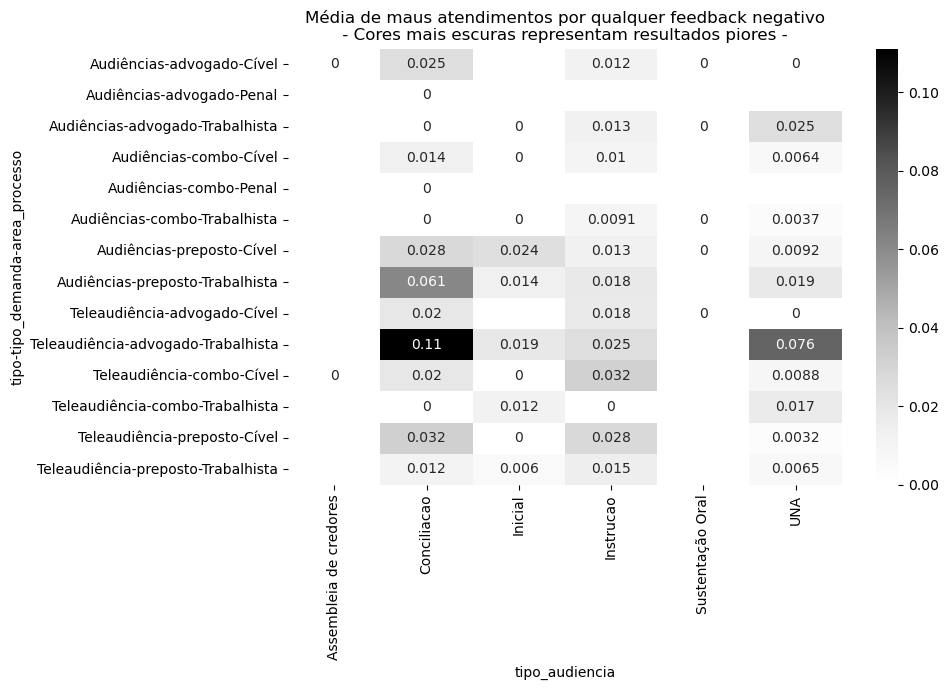

In [6]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(10, 7 )
    )

df_neg = (
    df_any_bad_result.groupby(
        ['tipo', 'tipo_demanda', 'area_processo', 'tipo_audiencia']
        )
        ['resultado_negativo']
        .agg('mean')
        .unstack()
        )

sns.heatmap(
    df_neg,
    annot=True,
    cmap='Greys',
    ax=axes
)

axes.set_title(
    f'Média de maus atendimentos por qualquer feedback negativo\n' \
    ' - Cores mais escuras representam resultados piores - ' 
)


plt.tight_layout()

Numa perspectiva geral é importante notar, portanto, que as **teleudiências** com **advogados** na seara **trabalhista**, até então, representaram a maior parte dos problemas identificados. O fenômeno ocorre especialmente em audiências de **conciliação** e audiências do tipo **UNA**.

Esse fenômeno é particularmente importante de se observar devido ao fato de que as varas trabalhistas representam uma parcela significativa da atuação de acordo com a base apresentada, aliado ao fato de que as audiências UNA são aquelas em que são produzidos todos os atos na Justiça do Trabalho.

Um evento negativo nesta audiência pode impactar o negócio de forma prejudicial e proporcional à sua importância.

É importante salientar, neste momento, que as atividades referentes às atuações em varas criminais, ou seja, em processos penais, representam uma parcela muito pequena da base.

In [7]:
(
    df['area_processo']
    .value_counts(normalize=True)
    .apply(lambda x: f'{x:.4f}%')
    .reset_index()

)

,area_processo,proportion
0,Cível,0.6036%
1,Trabalhista,0.3962%
2,Penal,0.0001%


## Modelo preditivo

*Quais solicitações tem mais risco de falha?*

O modelo RandomForest é um bom candidato para realizar esta tarefa de classificação em razão:
* Da sua alta acurácia
* Da relativa dificuldade de causar overfitting
* Da iberdade para lidar com features em escalas diferentes
* 


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [9]:
bad_results_c = ['houve_revelia', 'houve_ausencia', 'houve_ma_atuacao']

In [10]:
(
    pd.concat([
        df['houve_revelia'].value_counts(normalize=True),
        df['houve_ausencia'].value_counts(normalize=True),
        df['houve_ma_atuacao'].value_counts(normalize=True)],
        axis=1
    )
)

,proportion,proportion,proportion
0,0.998933,0.986732,0.997933
1,0.001067,0.013268,0.002067


In [11]:
# Não há valores nulos na amostra.
# Não há necessidade, neste momento, de decidir
# o tratamento de dados adequado, portanto.

df[bad_results_c].isnull().sum()

houve_revelia       0
houve_ausencia      0
houve_ma_atuacao    0
dtype: int64

In [12]:
# features selecionadas para a tentativa de determinar o comportamento
# dos clientes

dummy_c = [
    'tipo',             # Audiência ou Teleaudiencia
    'tipo_demanda',     # Advogado, Preposto
    'area_processo',    # Civel, Trabalhista
    'tipo_audiencia',   # Inicial, Instrução
    'orgao',            # Nome do Órgão
    ]

In [13]:
X = pd.get_dummies(
    df[dummy_c],
    drop_first=True,
    )

y = df[bad_results_c]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1148150585)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [15]:
acc = accuracy_score(y_test, y_pred)
print(acc)

0.9828333333333333


In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.13      0.22        15
           1       0.42      0.16      0.23       153
           2       0.40      0.14      0.21        28

   micro avg       0.43      0.15      0.23       196
   macro avg       0.50      0.14      0.22       196
weighted avg       0.44      0.15      0.23       196
 samples avg       0.00      0.00      0.00       196



c:\Users\plasmatic\miniconda3\envs\desafiodoc9\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\plasmatic\miniconda3\envs\desafiodoc9\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\plasmatic\miniconda3\envs\desafiodoc9\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital


Importância das features para 'houve_revelia':
                                                Feature  Importance
0                                    tipo_Teleaudiência    0.110511
2                                 tipo_demanda_preposto    0.039431
1                                    tipo_demanda_combo    0.034580
9                                    tipo_audiencia_UNA    0.034431
5                            tipo_audiencia_Conciliacao    0.030102
1686                          orgao_Foro de Uruoca - CE    0.027157
2653          orgao_Trabalhista de Pindamonhangaba - SP    0.022856
1229                  orgao_Foro de Pedro Leopoldo - MG    0.022131
205   orgao_Foro Regional de Santa Cruz - Rio de Jan...    0.020163
2568              orgao_Trabalhista de João Pessoa - PB    0.020069


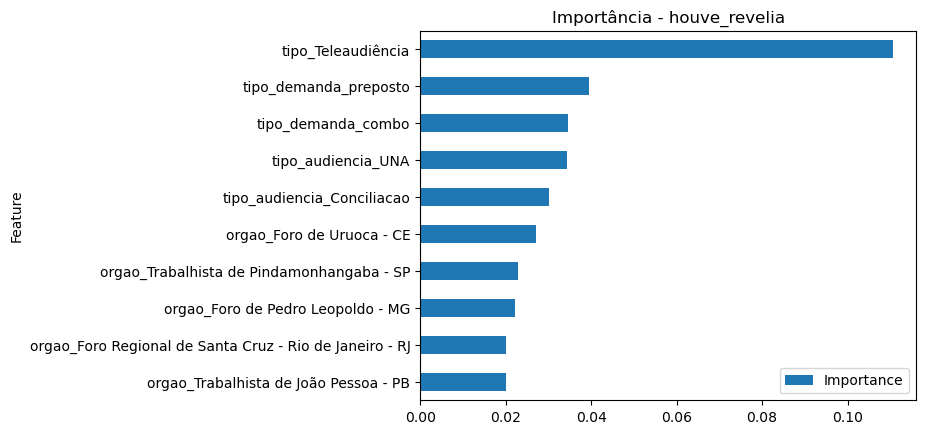


Importância das features para 'houve_ausencia':
                                                Feature  Importance
0                                    tipo_Teleaudiência    0.123618
2                                 tipo_demanda_preposto    0.079221
1                                    tipo_demanda_combo    0.060978
1926  orgao_Juizado Especial Cível Anexo UNISA - For...    0.023903
2724                orgao_Trabalhista de São Borja - RS    0.023682
1944  orgao_Juizado Especial Cível de Juiz de Fora - MG    0.023605
1849                    orgao_Jec - CIC Zona Leste - SP    0.022134
1111                         orgao_Foro de Niterói - RJ    0.018825
2049  orgao_Procon Estadual de Pernambuco - Recife - PE    0.018450
1704                  orgao_Foro de Venâncio Aires - RS    0.018348


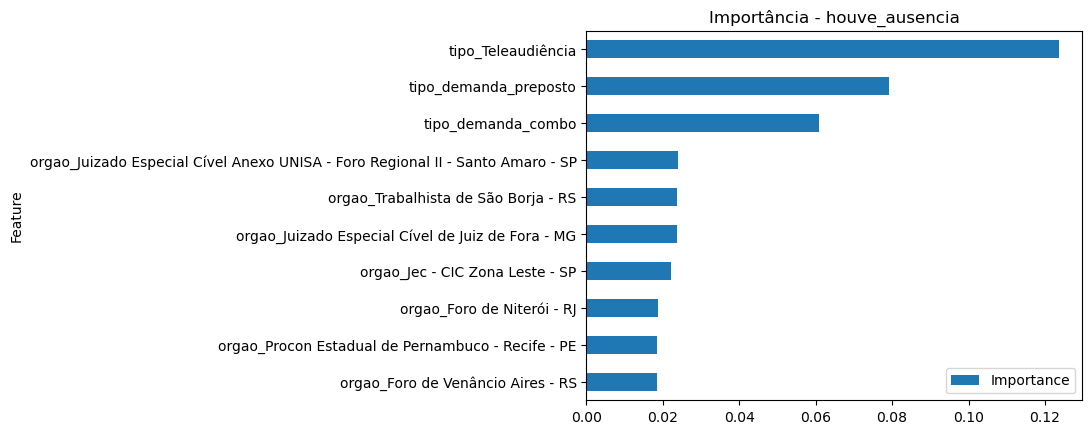


Importância das features para 'houve_ma_atuacao':
                                        Feature  Importance
2                         tipo_demanda_preposto    0.067095
7                      tipo_audiencia_Instrucao    0.031818
9                            tipo_audiencia_UNA    0.028869
1                            tipo_demanda_combo    0.026689
0                            tipo_Teleaudiência    0.025906
2000  orgao_Juizado Especial de Vespasiano - MG    0.025002
1160                orgao_Foro de Ouricuri - PE    0.024950
5                    tipo_audiencia_Conciliacao    0.021613
707                orgao_Foro de Fortaleza - CE    0.019946
376          orgao_Foro de Bento Gonçalves - RS    0.018940


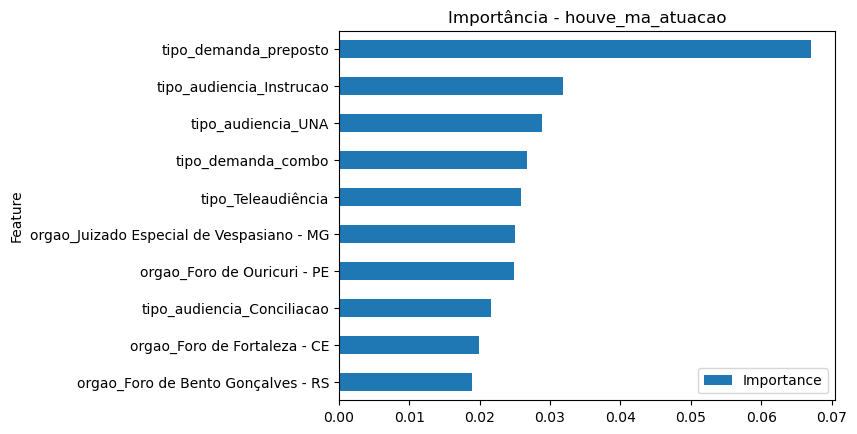

In [17]:
for i, target_name in enumerate(y.columns):
    importances = model.estimators_[i].feature_importances_
    feature_names = X.columns
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    print(f"\nImportância das features para '{target_name}':")
    print(feature_importance_df.head(10))

    # Gráfico (opcional)
    (
        feature_importance_df
        .sort_values('Importance', ascending=True)
        .tail(10)
        .plot(
            kind='barh',
            x='Feature',
            y='Importance',
            title=f'Importância - {target_name}')
            )
    plt.show()